✅ Model loaded from checkpoints/resnet50_arcface.pth
🔍 Building embeddings...


100%|██████████| 50/50 [00:01<00:00, 25.50it/s]


✅ Built embeddings for 50 identities.


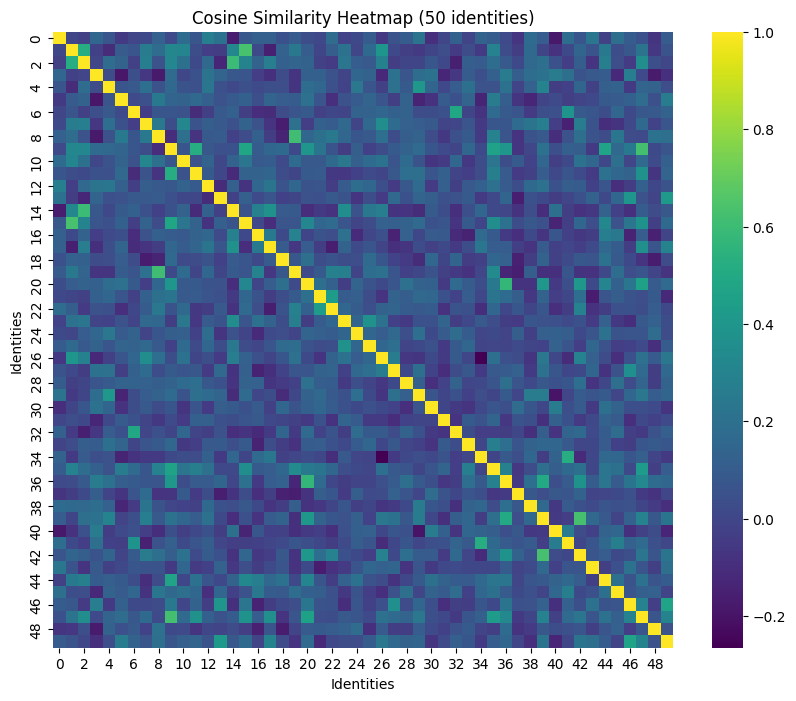


🔍 Inference Result:
Input: data/vggface2_split/val\n000052\0078_01.jpg
Top-1: n000052 (Score=0.6476)
Top-2: n000030 (Score=0.5205)
Top-3: n000004 (Score=0.5160)
Top-4: n000012 (Score=0.3937)
Top-5: n000010 (Score=0.3819)


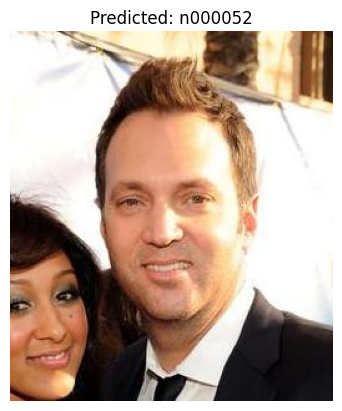

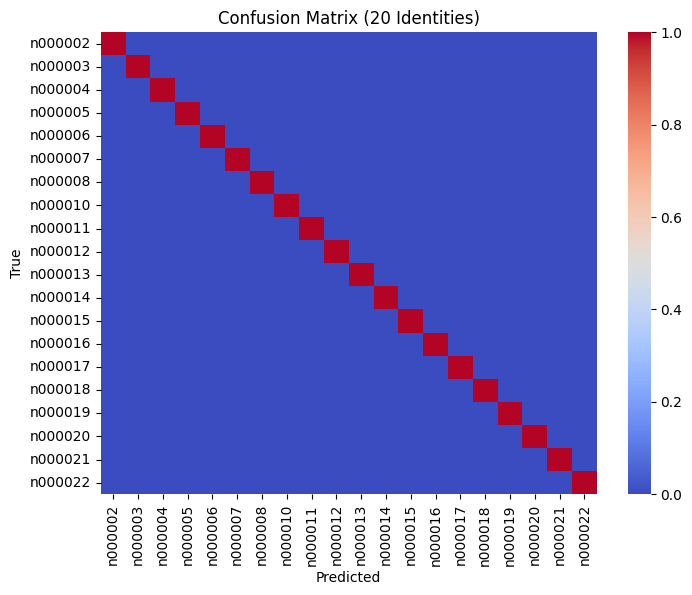

In [ ]:
# =============================================
# 🔬 Face Recognition Experiments Notebook
# =============================================
# 
# Project: Face Recognition (ResNet50 + ArcFace)
# Dataset: VGGFace2 subset
# =============================================

import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import random

# ======================
# 🔧 Config
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "checkpoints/resnet50_arcface.pth"
val_dir = "data/vggface2_split/val"

# ======================
# 🧩 Model Definition
# ======================
class FaceNet(nn.Module):
    def __init__(self, embedding_size=512):
        super(FaceNet, self).__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_model.fc = nn.Identity()
        self.backbone = base_model
        self.embedding = nn.Linear(2048, embedding_size)

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = nn.functional.normalize(x)
        return x

# ======================
# 🧠 Load Model
# ======================
model = FaceNet(embedding_size=512).to(device)
checkpoint = torch.load(model_path, map_location=device)

# adjust checkpoint if needed
if not any(k.startswith("backbone.") for k in checkpoint.keys()):
    new_state = {}
    for k, v in checkpoint.items():
        if k.startswith("fc."):
            new_state["embedding." + k.split("fc.")[-1]] = v
        else:
            new_state["backbone." + k] = v
    checkpoint = new_state

model.load_state_dict(checkpoint, strict=False)
model.eval()
print(f"✅ Model loaded from {model_path}")

# ======================
# 📦 Data Transform
# ======================
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# ======================
# 🧬 Embedding Extraction
# ======================
def extract_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(tensor).cpu().numpy().flatten()
    return emb

# ======================
# 🏗️ Build Embeddings
# ======================
print("🔍 Building embeddings...")
identities = sorted(os.listdir(val_dir))
gallery_embeddings = []
gallery_labels = []

for person in tqdm(identities[:50]):  # subset for visualization
    person_dir = os.path.join(val_dir, person)
    img_files = [f for f in os.listdir(person_dir) if f.lower().endswith(('.jpg', '.png'))]
    if not img_files:
        continue
    img_path = os.path.join(person_dir, img_files[0])
    emb = extract_embedding(img_path)
    gallery_embeddings.append(emb)
    gallery_labels.append(person)

gallery_embeddings = np.array(gallery_embeddings)
gallery_embeddings = normalize(gallery_embeddings)

print(f"✅ Built embeddings for {len(gallery_labels)} identities.")

# ======================
# 📈 Similarity Matrix
# ======================
similarity = np.matmul(gallery_embeddings, gallery_embeddings.T)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity, cmap='viridis')
plt.title("Cosine Similarity Heatmap (50 identities)")
plt.xlabel("Identities")
plt.ylabel("Identities")
plt.show()

# ======================
# 🎯 Random Inference Test
# ======================
random_person = random.choice(gallery_labels)
person_dir = os.path.join(val_dir, random_person)
test_img = random.choice(os.listdir(person_dir))
test_img_path = os.path.join(person_dir, test_img)

test_emb = extract_embedding(test_img_path)
test_emb = normalize(test_emb.reshape(1, -1))
scores = np.matmul(test_emb, gallery_embeddings.T).flatten()

top_idx = np.argsort(-scores)[:5]

print("\n🔍 Inference Result:")
print(f"Input: {test_img_path}")
for rank, idx in enumerate(top_idx, start=1):
    print(f"Top-{rank}: {gallery_labels[idx]} (Score={scores[idx]:.4f})")

# visualize input image
img = Image.open(test_img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {gallery_labels[top_idx[0]]}")
plt.show()

# ======================
# ⚙️ Confusion Matrix (Optional)
# ======================
# Build confusion matrix for first few identities
y_true = []
y_pred = []
for person in identities[:20]:
    person_dir = os.path.join(val_dir, person)
    img_files = [f for f in os.listdir(person_dir) if f.lower().endswith(('.jpg', '.png'))]
    if not img_files:
        continue
    img_path = os.path.join(person_dir, img_files[0])
    emb = extract_embedding(img_path)
    emb = normalize(emb.reshape(1, -1))
    scores = np.matmul(emb, gallery_embeddings.T).flatten()
    pred = gallery_labels[np.argmax(scores)]
    y_true.append(person)
    y_pred.append(pred)

cm = confusion_matrix(y_true, y_pred, labels=gallery_labels[:20])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, xticklabels=gallery_labels[:20], yticklabels=gallery_labels[:20], cmap='coolwarm')
plt.title("Confusion Matrix (20 Identities)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
